# StyleGAN2

![styleGAN2 generated image sample](https://github.com/sony/nnabla-examples/raw/master/GANs/stylegan2/images/sample.png)

This example demonstrates face image generation using [StyleGAN2](https://github.com/NVlabs/stylegan2). StyleGAN2 is one of the generative models which can generate high-resolution images.


# Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

In [ ]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/GANs/stylegan2

     |████████████████████████████████| 43.2MB 79kB/s 
     |████████████████████████████████| 18.2MB 174kB/s 
     |████████████████████████████████| 133kB 38.8MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 7.4MB 39.6MB/s 
ERROR: botocore 1.20.58 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
Cloning into 'nnabla-examples'...
remote: Enumerating objects: 4825, done.
remote: Counting objects: 100% (590/590), done.
remote: Compressing objects: 100% (365/365), done.
remote: Total 4825 (delta 269), reused 458 (delta 215), pack-reused 4235
Receiving objects: 100% (4825/4825), 173.00 MiB | 29.64 MiB/s, done.
Resolving deltas: 100% (2477/2477), done.
/content/nnabla-examples/GANs/stylegan2


# Get the pretrained weights
Now we will get the pretrained weights for styleGAN2, then import some modules and do some preparation for the latter part.

In [ ]:
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stylegan2/styleGAN2_G_params.h5
from generate import *
from IPython.display import Image, display
ctx = get_extension_context("cudnn")
nn.set_default_context(ctx)

num_layers = 18
output_dir = 'results'

nn.load_parameters("styleGAN2_G_params.h5")

--2021-04-27 06:13:18--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stylegan2/styleGAN2_G_params.h5
Resolving nnabla.org (nnabla.org)... 13.227.222.55, 13.227.222.17, 13.227.222.59, ...
Connecting to nnabla.org (nnabla.org)|13.227.222.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121643776 (116M) [binary/octet-stream]
Saving to: ‘styleGAN2_G_params.h5’

styleGAN2_G_params. 100%[===================>] 116.01M   259MB/s    in 0.4s    

2021-04-27 06:13:18 (259 MB/s) - ‘styleGAN2_G_params.h5’ saved [121643776/121643776]



2021-04-27 06:13:18,894 [nnabla][INFO]: Initializing CPU extension...
2021-04-27 06:13:20,709 [nnabla][INFO]: Initializing CUDA extension...
2021-04-27 06:13:20,791 [nnabla][INFO]: Initializing cuDNN extension...


# StyleGAN2 input config

In styleGAN2, the noise input **z** is fed to the **mapping network** to produce the latent code **w**. Then **w** is modified via **truncation trick** and finally the modified latent code **w'** is injected to the **synthesis network**.

With multiple latent codes **w'** coming from the **mapping network**, **synthesis network** transforms the incoming tensor and gradually converts it to an image. 

This is how styleGAN2 generates photo-realistic high resolution images. 

In the following cell,  you will choose the random seed used for sampling the noise input **z**, the value for **truncation trick**, and another random seed used for the additional noise input.

In [ ]:
#@markdown Choose the seed for noise input **z**. (This drastically changes the result)
latent_seed = 1000  #@param {type: "slider", min: 0, max: 1000, step:1}

#@markdown Choose the value for truncation trick.
truncation_psi = 0.5  #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}

#@markdown Choose the seed for stochasticity input.  (This slightly changes the result)
noise_seed = 500  #@param {type: "slider", min: 0, max: 1000, step:1}

#@markdown Number of images to generate
batch_size = 1  #@param {type: "slider", min: 0, max: 20, step:1}

# Now let's run StyleGAN2!
Execution the following cell will run the styleGAN2. You can see by changing the value used for **truncation trick**, you will get the different results.

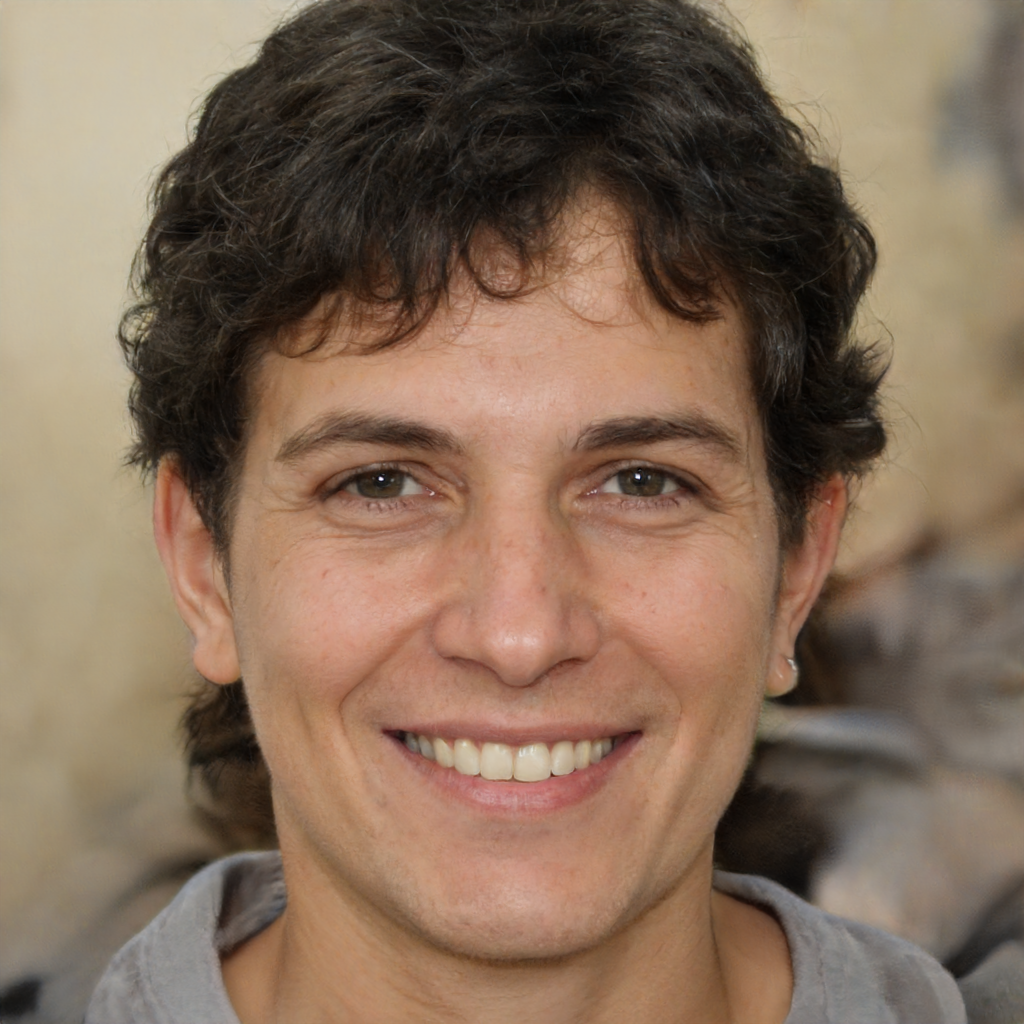

In [ ]:
rnd = np.random.RandomState(latent_seed)
z = rnd.randn(batch_size, 512)

nn.set_auto_forward(True) 

style_noise = nn.NdArray.from_numpy_array(z)
style_noises = [style_noise for _ in range(2)] 

rgb_output = generate(batch_size, style_noises, noise_seed, mix_after=7, truncation_psi=truncation_psi) 

images = convert_images_to_uint8(rgb_output, drange=[-1, 1])

# Display all the images
for i in range(batch_size):
  filename = f'seed{latent_seed}_{i}.png'
  imsave(filename, images[i], channel_first=True)
  display(Image(filename, width=512, height=512))

# Try Style Mixing

![styleGAN2 generated image sample](https://github.com/sony/nnabla-examples/raw/master/GANs/stylegan2/images/style_mixing_sample.png)

As described above, in styleGAN2, **synthesis network** receives latent code **w** multiple times and generates images. In the previous generation, latent code **w** which **synthesis network** receives is made from one single noise input **z**. In this case, we can say that **w** controls the *style* of the generated image.

Given that, with a *different* latent code **w2**, made from another noise input **z2**, **synthesis network** can generate a completely different image. So, what if we use both **w** and **w2**...? That is, *style mixing*.

To be specific, using 2 latent codes **w** and **w2**, **synthesis network** can generate the image which contains both elements (i.e. hair style, face components), present in images made from **w** (controling coarse style) and **w2** (controling fine style).

In the following cell, you will choose one more random seed used for sampling another noise input **z2**. 

You can also choose from which layer it receives the additional latent code **w2**. It slightly changes the result, so try various patterns.

In [27]:
#@title StyleGAN2 style mixing config
#@markdown Choose seed for the primary noise input **z**. This will represent coarse style.
latent_seed = 500  #@param {type: "slider", min: 0, max: 1000, step:1}
# latent_seed = 819 (default)

#@markdown Choose seed for the secondary noise input **z2**. This will represent fine style.
latent_seed2 = 600  #@param {type: "slider", min: 0, max: 1000, step:1}
# latent_seed2 = 117 (default)

#@markdown Choose from which layer to use the secondary latent code **w2**.
mix_after = 2  #@param {type: "slider", min: 0, max: 17, step:1}
# mix_after = 4 (default)

#@markdown Choose seed for stochasticity input.
noise_seed = 500  #@param {type: "slider", min: 0, max: 1000, step:1}

#@markdown Choose the value for truncation trick.
truncation_psi = 0.7  #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}

#@markdown Number of images made solely from coarse style noise
batch_size_A = 2  #@param {type: "slider", min: 0, max: 20, step:1}

#@markdown Number of images made solely from fine style noise
batch_size_B = 4  #@param {type: "slider", min: 0, max: 20, step:1}

# Let's run style mixing.

Running this cell executes style mixing and displays a generated mixed image and images made solely from **w** / **w2**.

In [28]:
rnd1 = np.random.RandomState(latent_seed)
z1 = nn.NdArray.from_numpy_array(rnd1.randn(batch_size_A, 512))

rnd2 = np.random.RandomState(latent_seed2)
z2 = nn.NdArray.from_numpy_array(rnd2.randn(batch_size_B, 512))

nn.set_auto_forward(True)

mix_image_stacks = []
for i in range(batch_size_A):
  image_column = []
  for j in range(batch_size_B):
    style_noises = [F.reshape(z1[i], (1, 512)), F.reshape(z2[j], (1, 512))]
    rgb_output = generate(1, style_noises, noise_seed, mix_after, truncation_psi)
    image_column.append(convert_images_to_uint8(rgb_output, drange=[-1, 1])[0])
  image_column = np.concatenate([image for image in image_column], axis=2)
  mix_image_stacks.append(image_column)
mix_image_stacks = np.concatenate([image for image in mix_image_stacks], axis=1)

style_noises= [z1, z1]
rgb_output = generate(batch_size_A, style_noises, noise_seed, mix_after, truncation_psi)
image_A = convert_images_to_uint8(rgb_output, drange=[-1, 1])
image_A = np.concatenate([image for image in image_A], axis=1)

style_noises = [z2, z2]
rgb_output = generate(batch_size_B, style_noises, noise_seed, mix_after, truncation_psi)
image_B = convert_images_to_uint8(rgb_output, drange=[-1, 1])
image_B = np.concatenate([image for image in image_B], axis=2)

top_image = 255 * np.ones(rgb_output[0].shape).astype(np.uint8)

top_image = np.concatenate((top_image, image_B), axis=2)
grid_image = np.concatenate((image_A, mix_image_stacks), axis=2)
grid_image = np.concatenate((top_image, grid_image), axis=1)

imsave("grid.png", grid_image, channel_first=True)
display(Image("grid.png", width=256*(batch_size_B+1), height=256*(batch_size_A+1)))

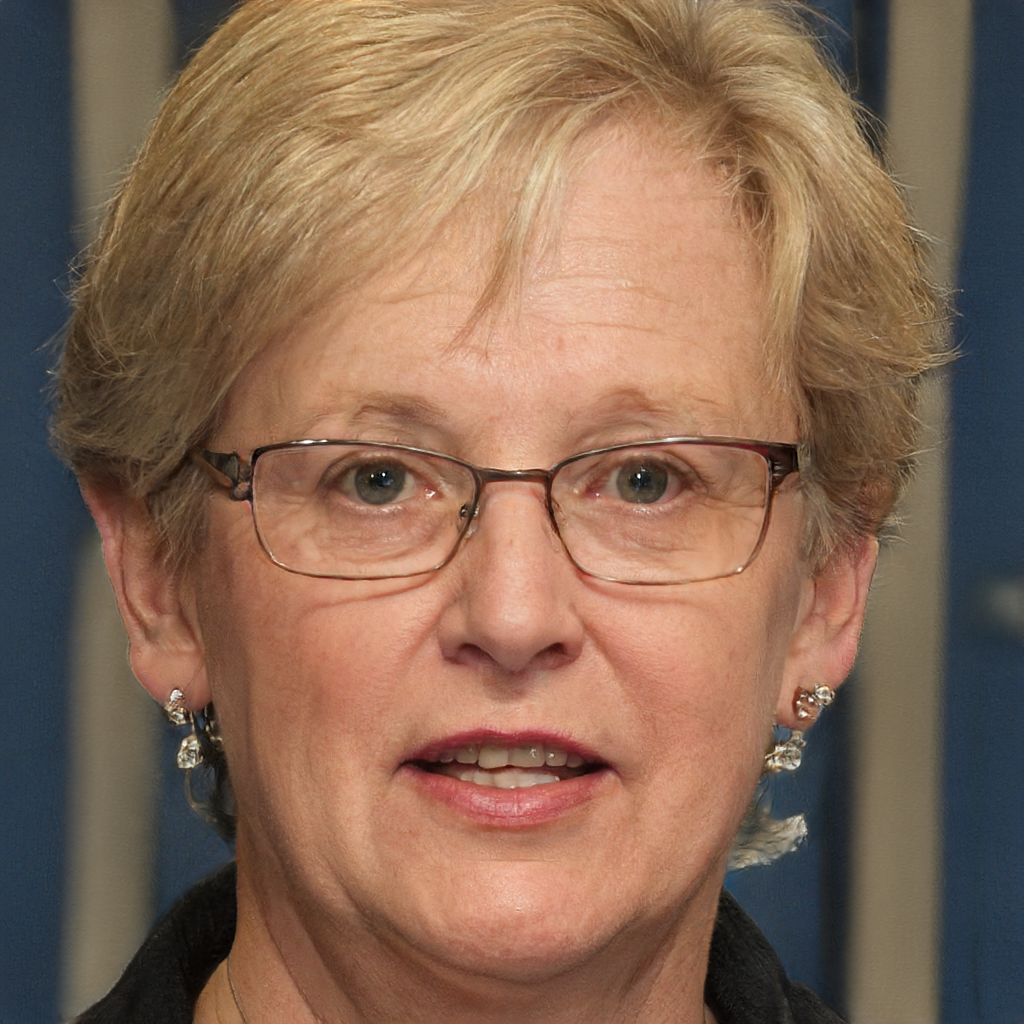

In [ ]:
z3 = (z2[0]+z2[1]+z2[2]+z2[3])/4

z_latnet = z1[0]-z1[1]+z3

style_noises = [F.reshape(z_latnet, (1, 512)), F.reshape(z_latnet, (1, 512))]

rgb_output = generate(1, style_noises, noise_seed, mix_after, truncation_psi)
image_B = convert_images_to_uint8(rgb_output, drange=[-1, 1])
image_B = np.concatenate([image for image in image_B], axis=2)

imsave("latent.png", image_B, channel_first=True)
display(Image("latent.png", width=256*(batch_size_B+1), height=256*(batch_size_A+1)))